In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from circle_generator import Circles
from loss import SegmentationLoss, ImageLoss
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt
import copy
import random
from img_segm_img_model import ImageSegmentationImageModel
from eunet import EUnet

In [2]:
def generate_data(predata, batch_sizes):
    np.random.seed(42)
    data = {}
    splits = ['train', 'val', 'test']
    for batch_size, split in zip(batch_sizes, splits):
        images, segmentation = predata.get_train_batch(batch_size)
        images = Variable(torch.from_numpy(images).float().cuda(0), requires_grad=False)
        segmentation = Variable(torch.from_numpy(segmentation).cuda(0), requires_grad=False)
        data[split] = (images, segmentation)
    return data

In [3]:
def train(data, net, number_without_segmentation, num_epoch, img_loss, segm_loss):
    train_loss_history = []
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        net.train(True)
        optimizer.zero_grad()
        generated_images, generated_segmentation = net.forward(data['train'][0])
        
        if number_without_segmentation > 0:
            train_loss = segm_loss(generated_segmentation[:-number_without_segmentation], 
                                   data['train'][1][:-number_without_segmentation])
        else:
            train_loss = segm_loss(generated_segmentation, data['train'][1])
            
        train_loss += 1000*img_loss(generated_images, data['train'][0])
        train_loss_history.append(train_loss.data[0])
        
        train_loss.backward()
        optimizer.step()
        
        net.train(False)
        generated_val_images, generated_val_segmentation = net.forward(data['val'][0])
        val_loss = segm_loss(generated_val_segmentation, data['val'][1])
        val_loss += 1000*img_loss(generated_val_images, data['val'][0])
        val_loss_history.append(val_loss.data[0])
        
        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = copy.deepcopy(net.state_dict())
            last_update = 0
        else:
            last_update += 1

        
    #net.load_state_dict(best_model_params)
        #print('---- epoch {} -----'.format(epoch))
        #print('loss on train = {}'.format(train_loss_history[-1]))
        #print('loss on validation = {}'.format(val_loss_history[-1]))
        
    return train_loss_history, val_loss_history, best_model_params

In [25]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

In [5]:
def test(net, data, segm_loss, img_loss):
    generated_images, generated_segmentation = net.forward(data['test'][0])

    segm_test_loss = segm_loss(generated_segmentation, data['test'][1]).data[0]
    l2_test_loss = img_loss(generated_images, data['test'][0]).data[0]
    #print('segmetation loss on test = {}'.format(segm_test_loss))
    #print('l2 loss on test = {}'.format(l2_test_loss))

    generated_images = generated_images.cpu().data.numpy()
    generated_segmentation = generated_segmentation.cpu().data.numpy()
    gt_images = data['test'][0].cpu().data.numpy()
    gt_segmentation = data['test'][1].cpu().data.numpy()

    #show_image_segm(generated_images, generated_segmentation, gt_images, gt_segmentation)
    return segm_test_loss, l2_test_loss, generated_images, generated_segmentation

### Experiments

we generated 192 training samples. We will use 64 of them with segmentation adding others to see whether the performance of network with be better adding unlabelled data. 

In [6]:
### generate data
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
data = generate_data(predata, [192, 32, 16])

In [7]:
### initialize network and save parameters
net = ImageSegmentationImageModel(input_dim=1, num_classes=3, batch_norm=True).cuda(0)
starting_parameters = copy.deepcopy(net.state_dict())
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

In [8]:
def experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 
                                    labelled_data_size, unlabelled_data_size, num_epoch=20000):

    net.load_state_dict(starting_parameters)

    data_current = copy.deepcopy(data)
    data_current['train'] = (data['train'][0][:labelled_data_size + unlabelled_data_size], 
                             data['train'][1][:labelled_data_size + unlabelled_data_size])

    train_loss_history, val_loss_history, early_stopping_params = train(data_current, net, unlabelled_data_size, 
                                                                        num_epoch, img_loss, segm_loss)

    plt.semilogy(train_loss_history, label='train, unlabeled data = {}'.format(unlabelled_data_size))
    plt.semilogy(val_loss_history, label='val, unlabeled data = {}'.format(unlabelled_data_size))
    
    plt.title('Training/validation loss with unlabelled data = {}'.format(unlabelled_data_size))
    plt.legend()
    plt.show()
    
    net.load_state_dict(early_stopping_params)

    test_results = test(net, data, segm_loss, img_loss)
    
    return test_results
    

In [9]:
history_segm_test, history_l2_test = [], []
segmentation_test, reconstruction_test = [], []

100%|██████████| 30000/30000 [53:33<00:00,  9.33it/s]


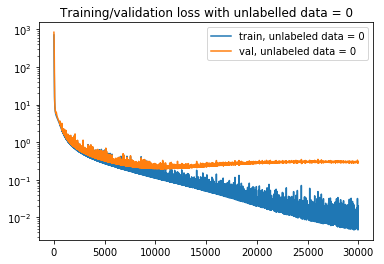

In [10]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 0, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [1:15:23<00:00,  6.63it/s]


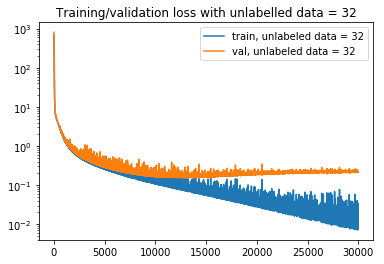

In [11]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 32, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [1:33:27<00:00,  5.35it/s]


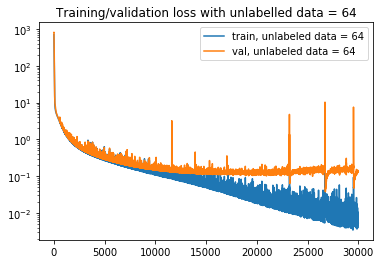

In [12]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 64, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [2:15:38<00:00,  3.69it/s]  


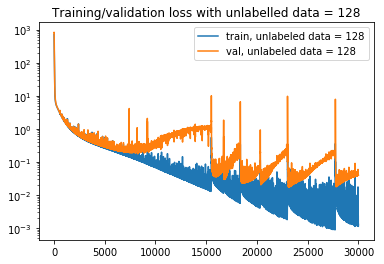

In [13]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 128, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

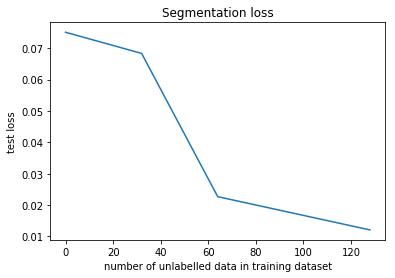

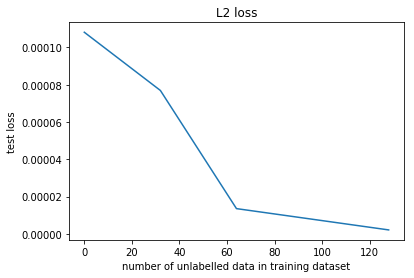

In [15]:
plt.title('Segmentation loss')
plt.xlabel('number of unlabelled data in training dataset')
plt.ylabel('test loss')
plt.plot([0, 32, 64, 128], history_segm_test)
plt.show()

plt.title('L2 loss')
plt.xlabel('number of unlabelled data in training dataset')
plt.ylabel('test loss')
plt.plot([0, 32, 64, 128], history_l2_test)
plt.show()

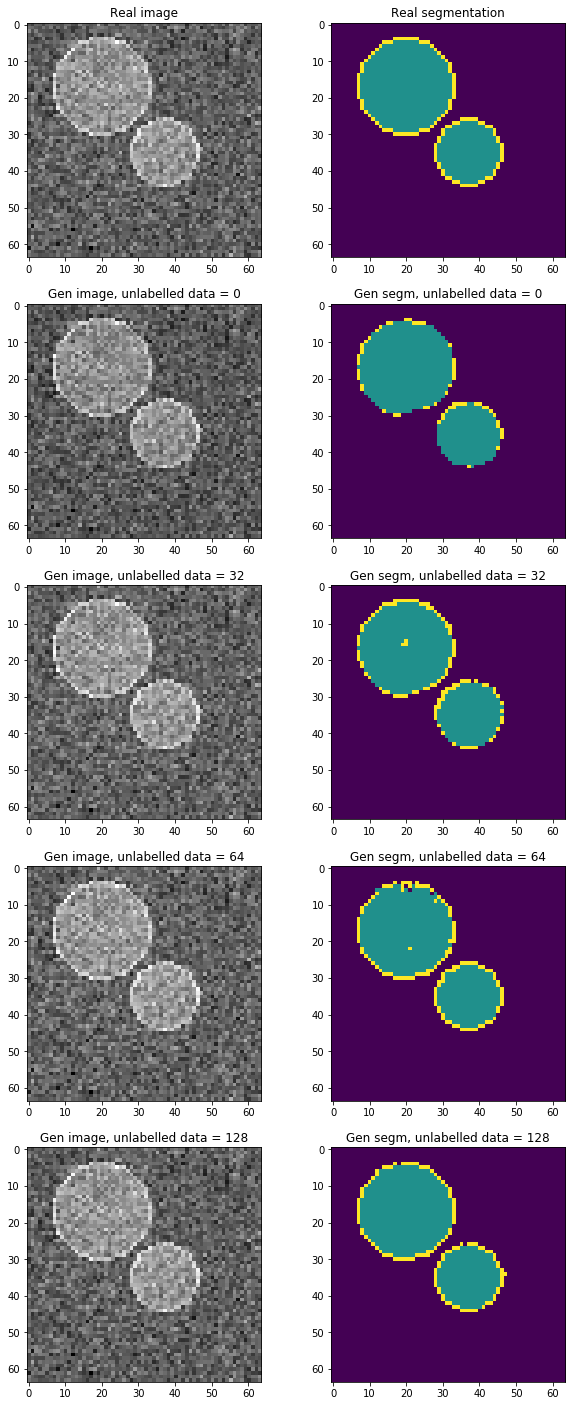

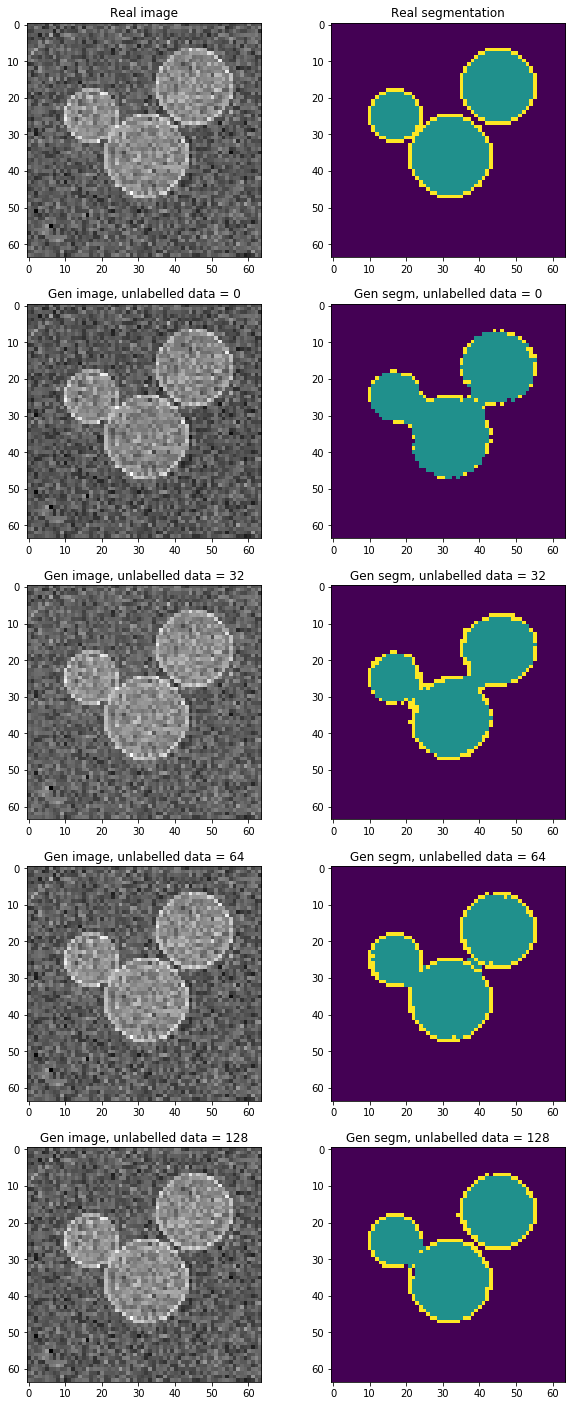

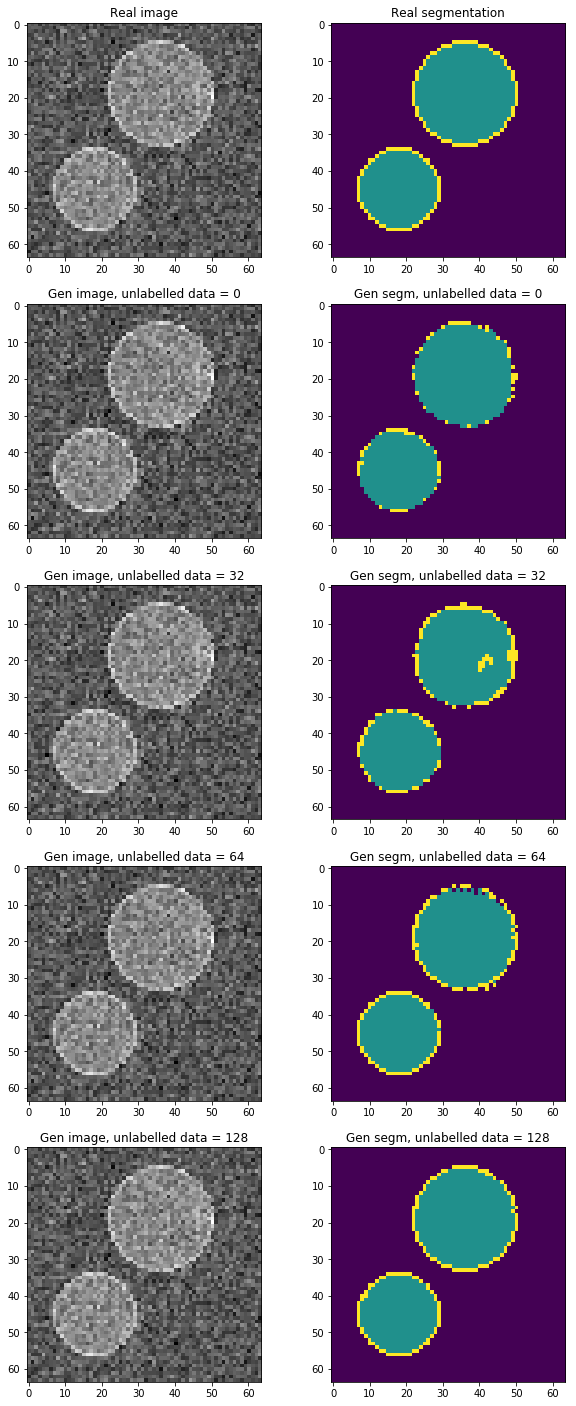

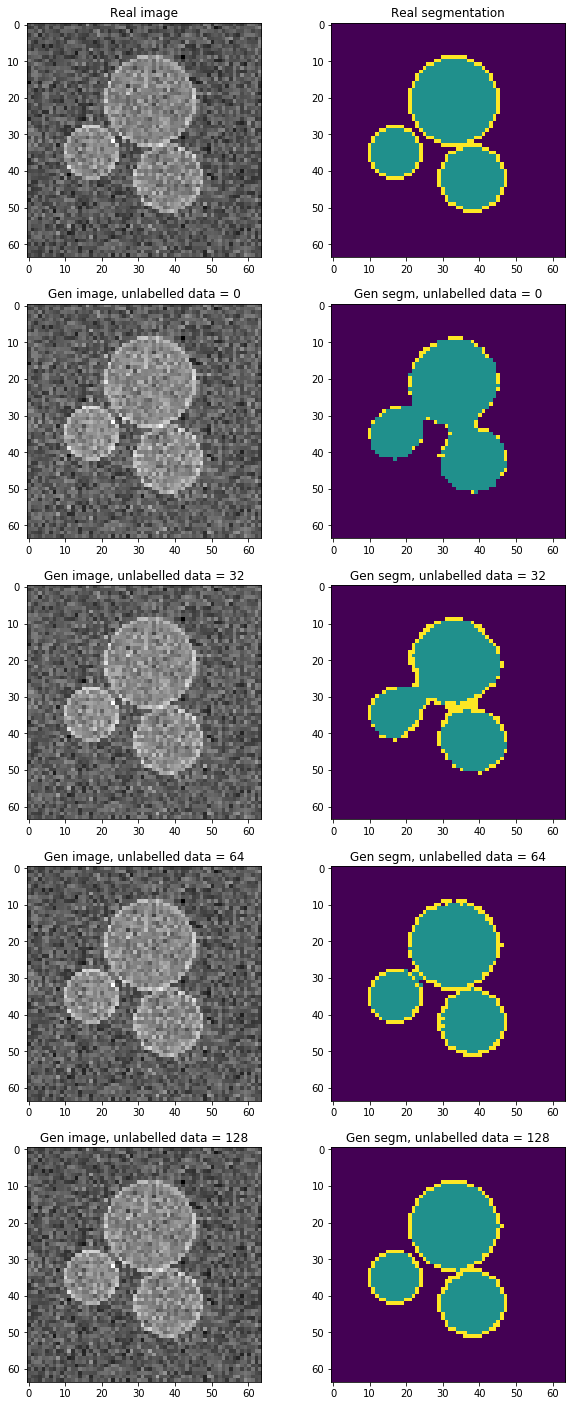

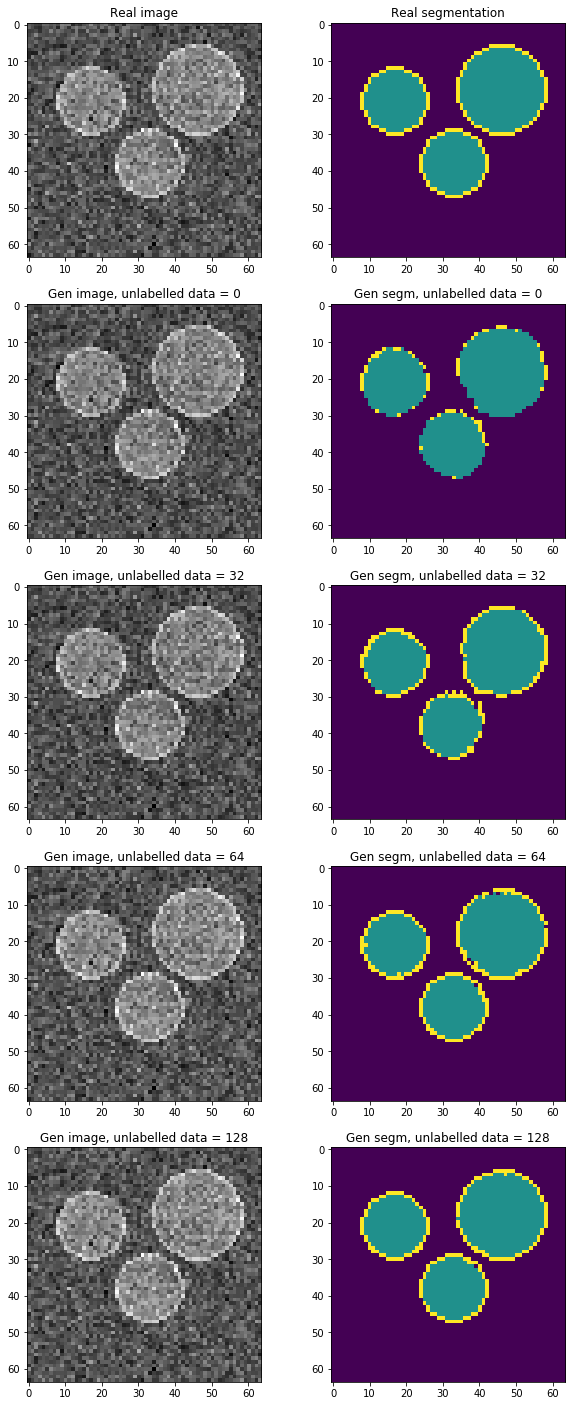

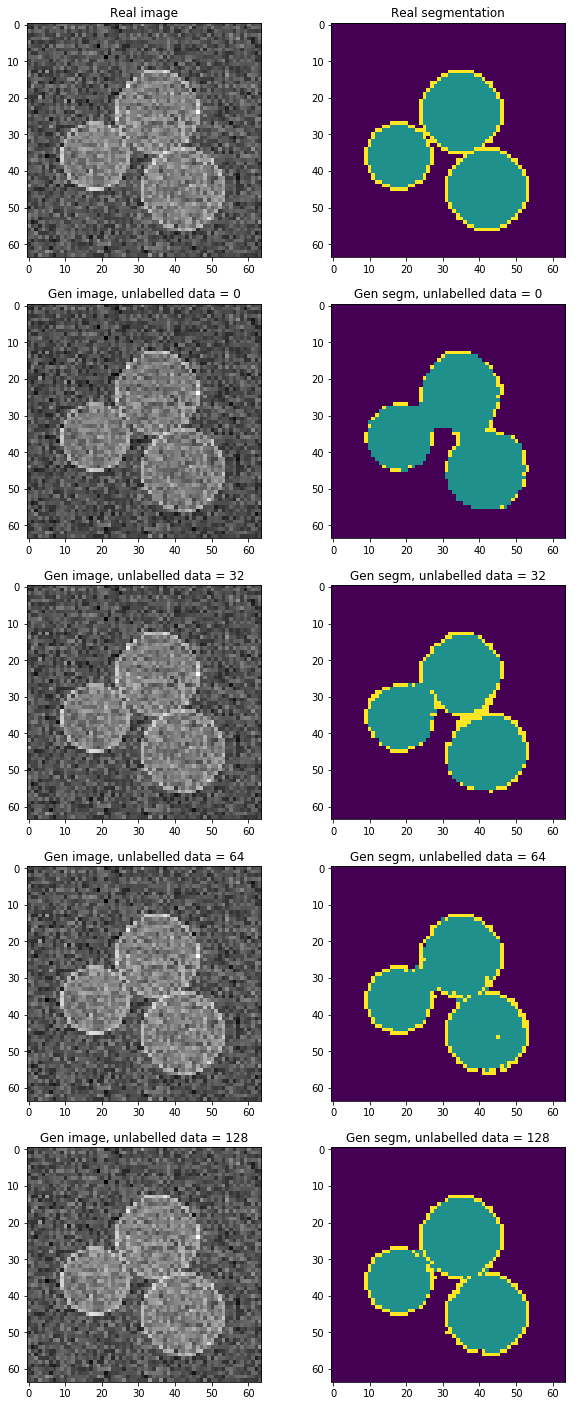

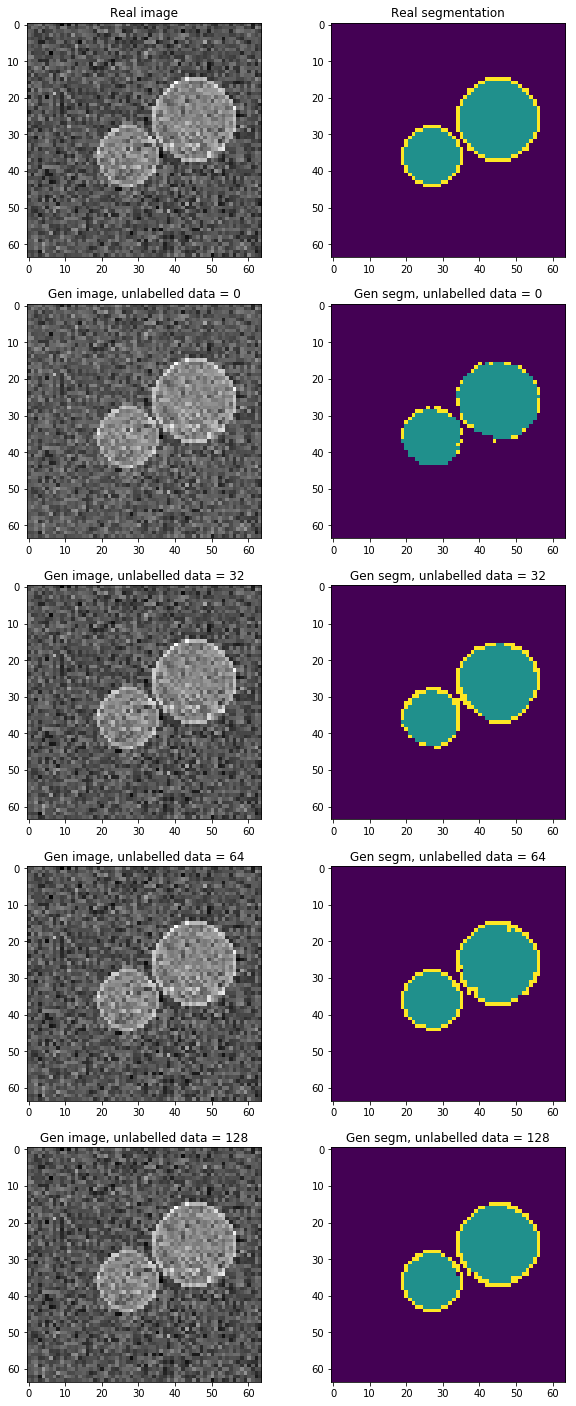

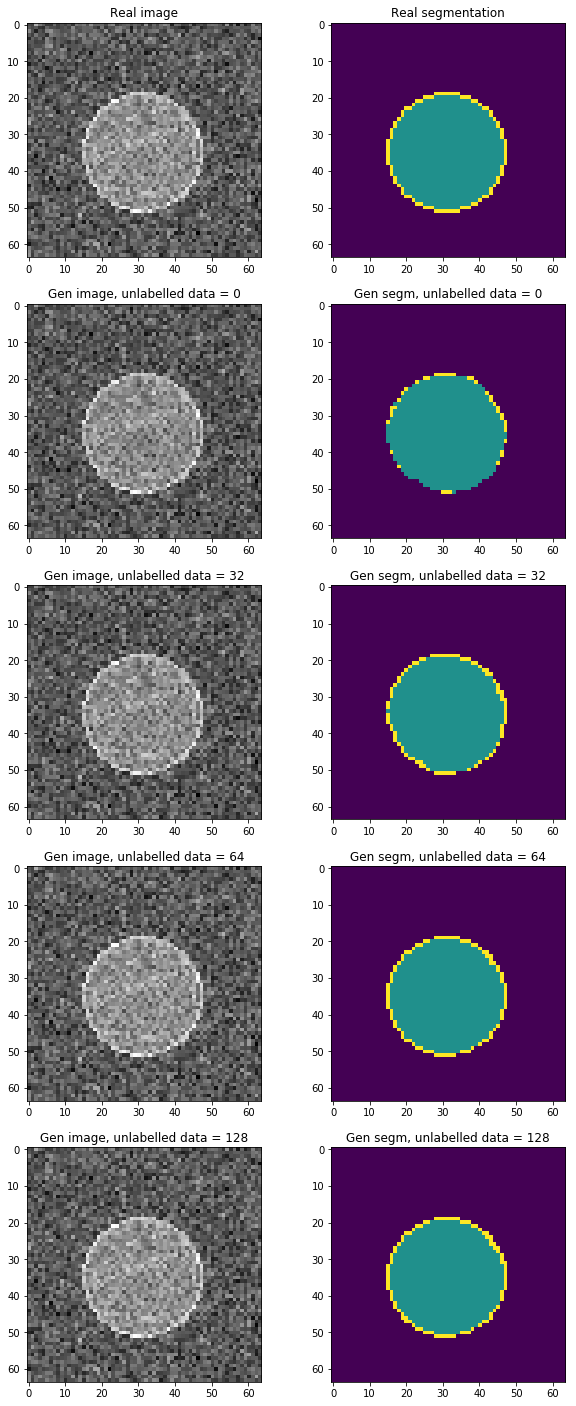

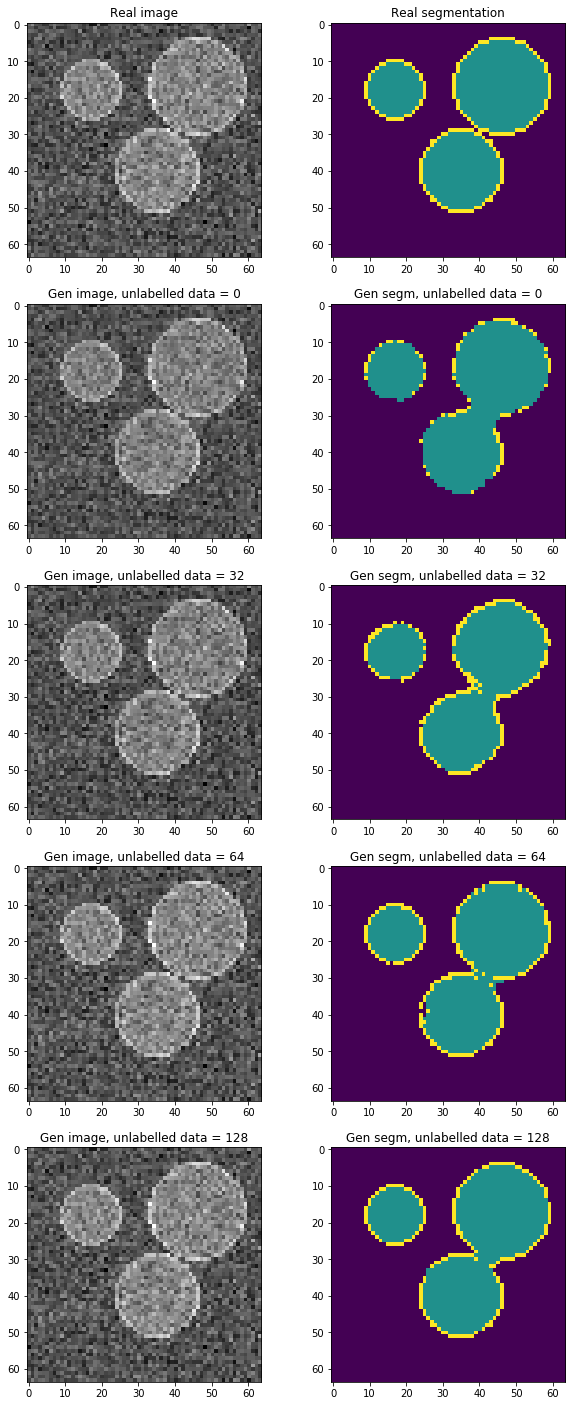

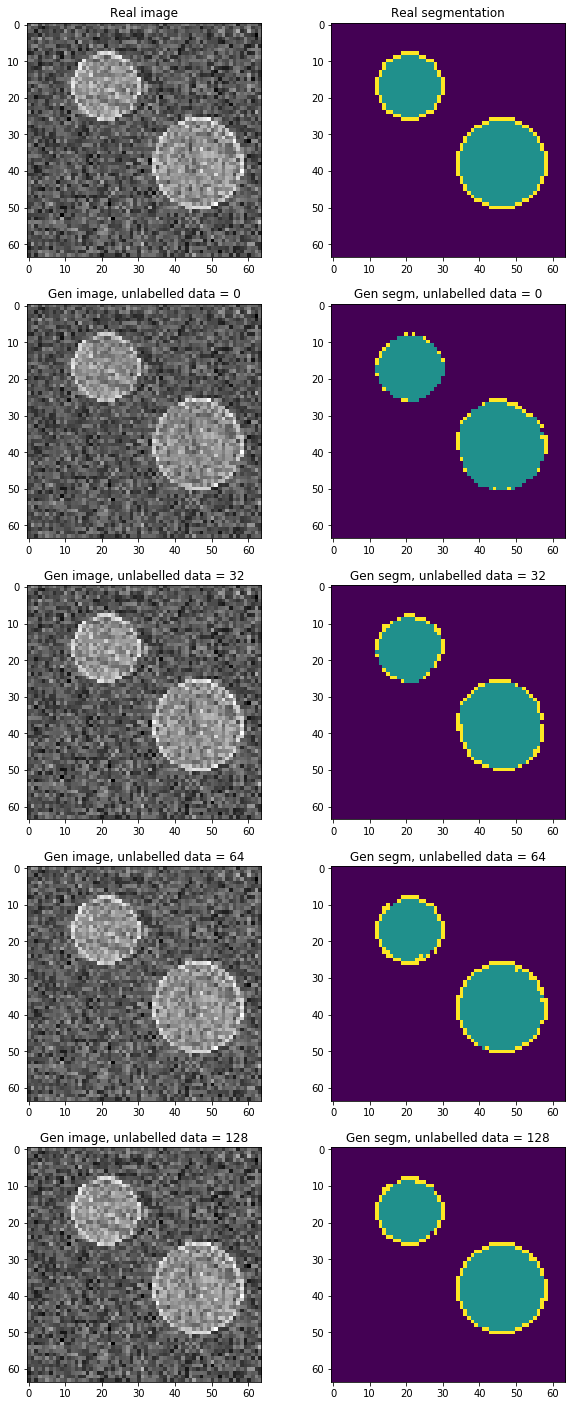

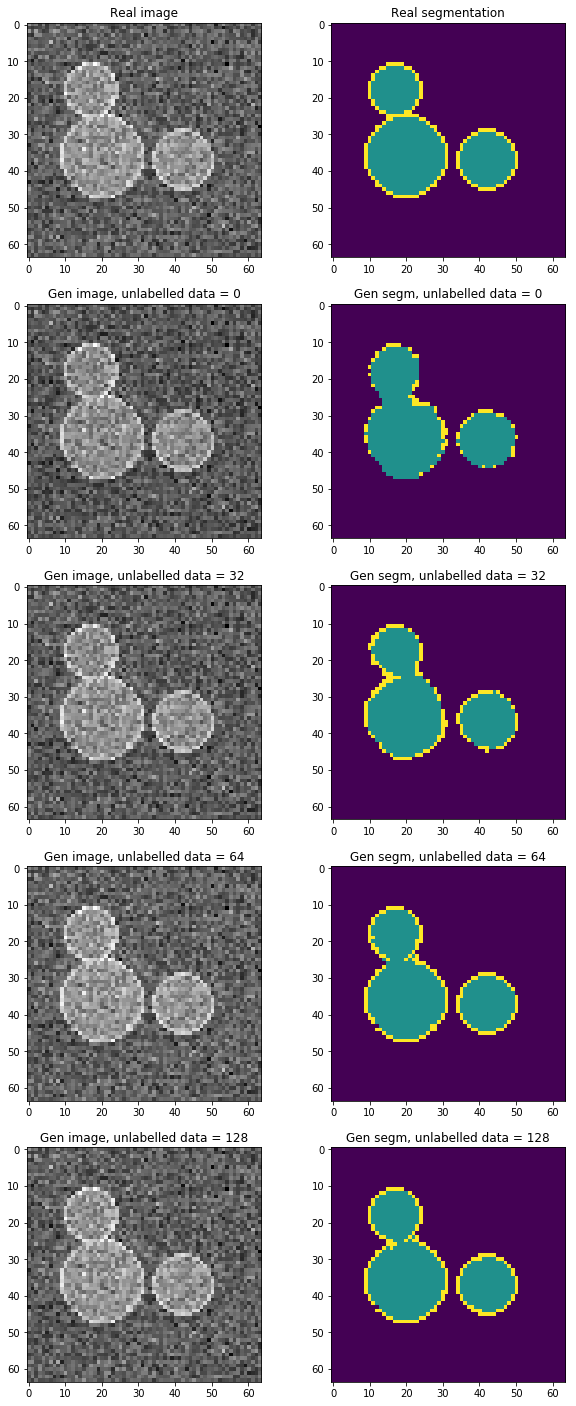

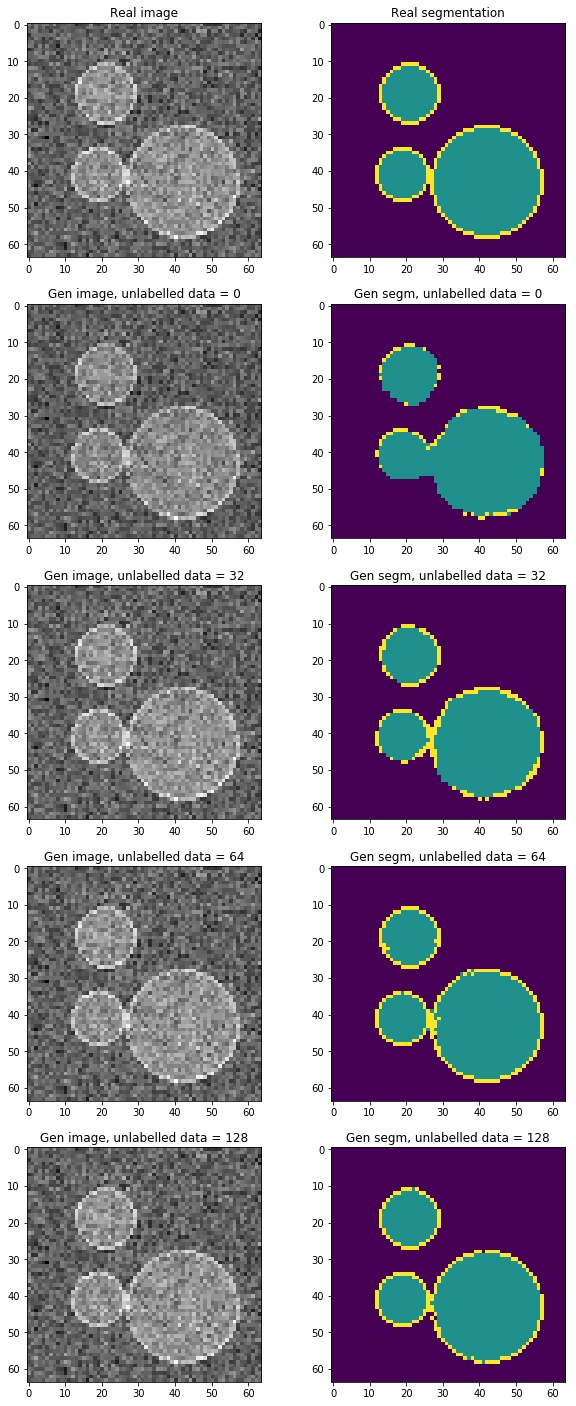

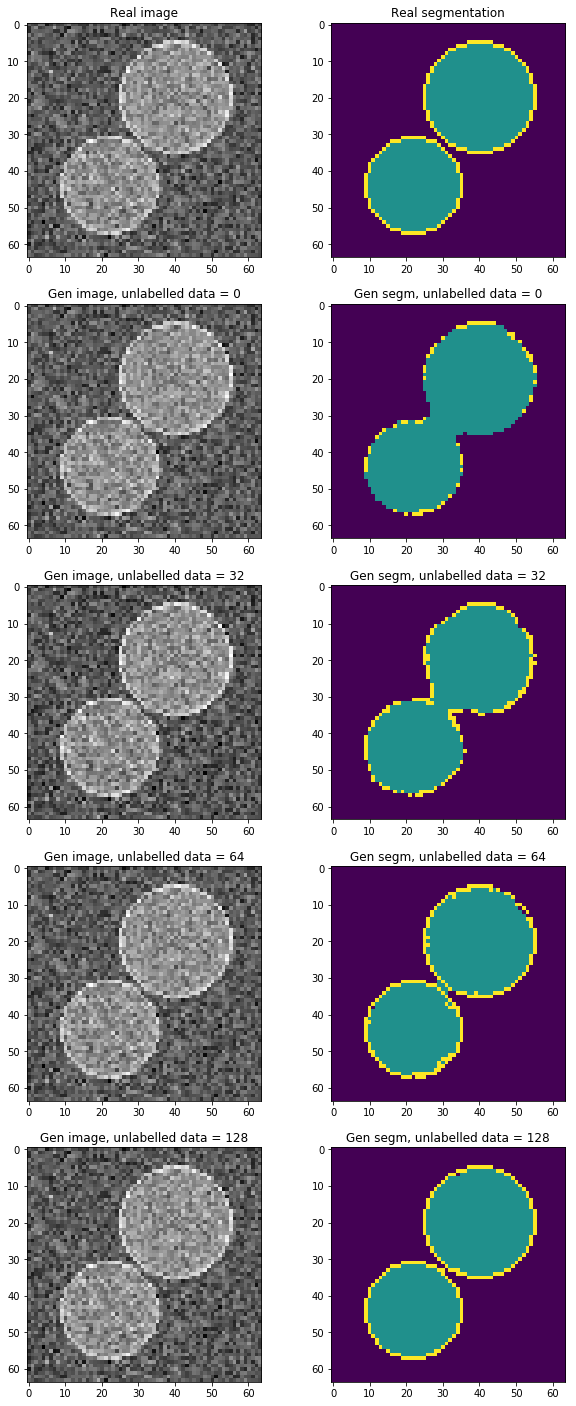

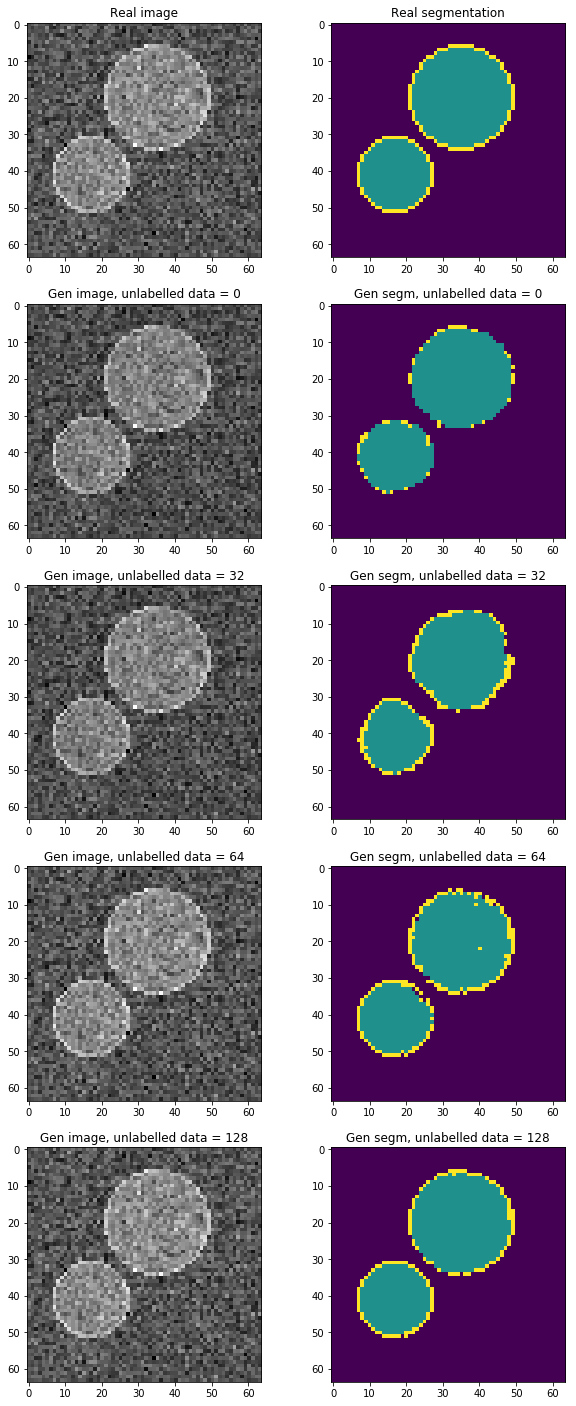

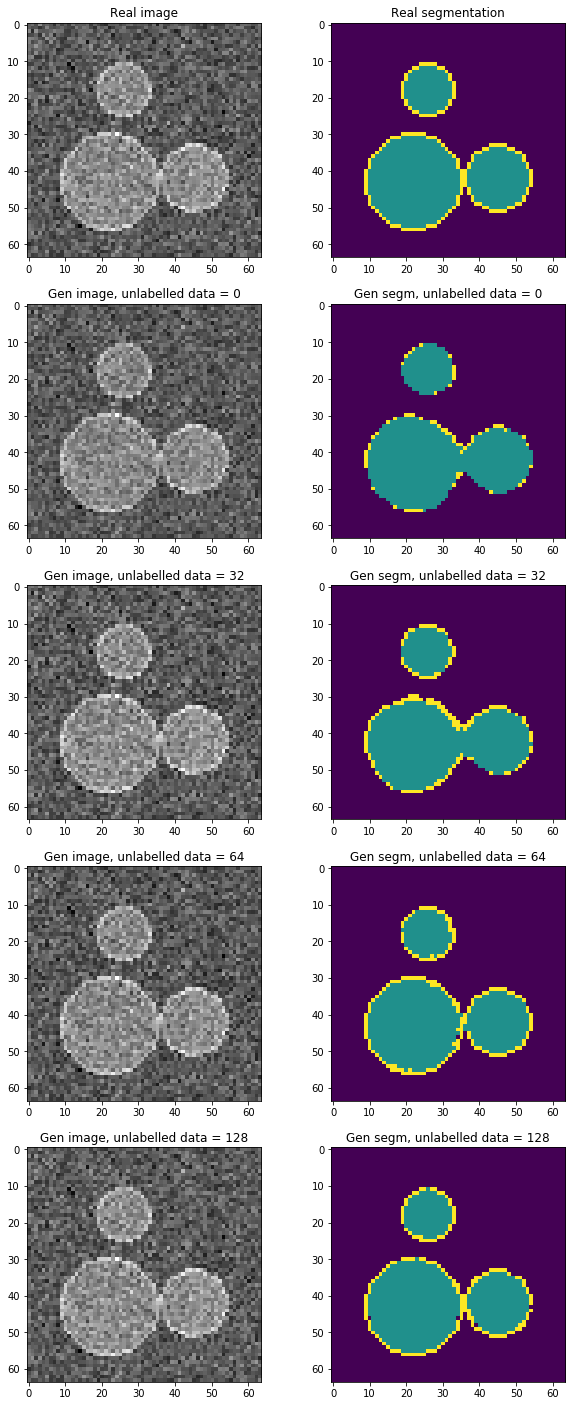

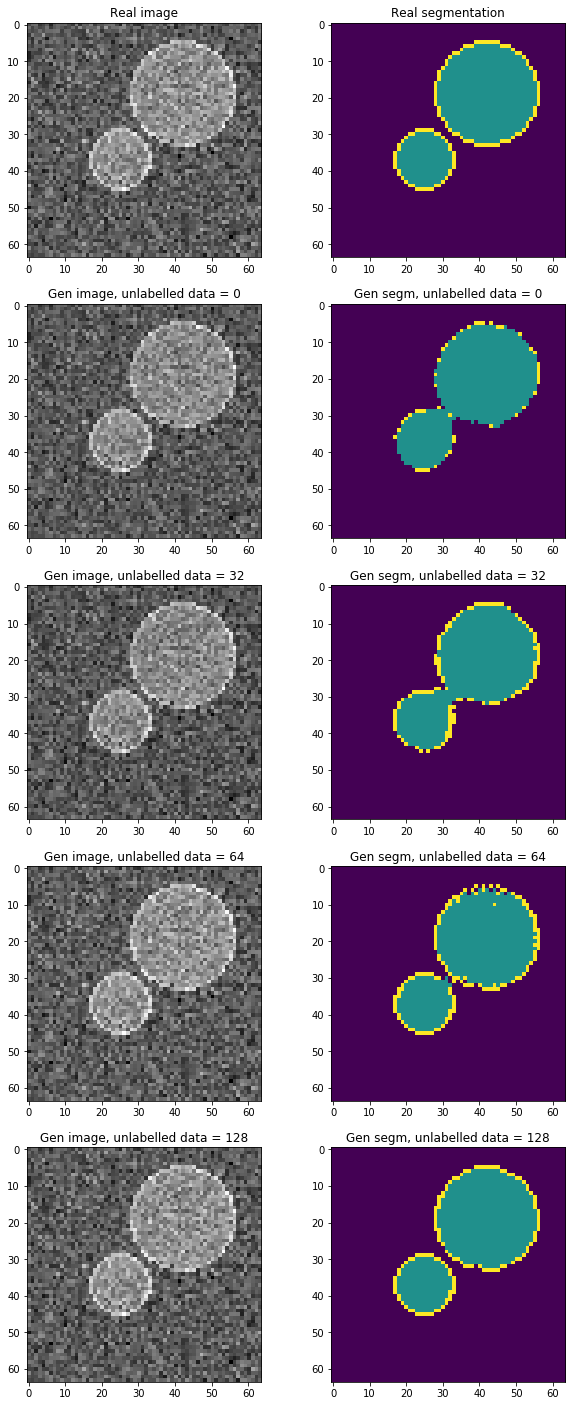

In [40]:
gt_images = data['test'][0].cpu().data.numpy()
gt_segms = data['test'][1].cpu().data.numpy()

for j, gt_image, gt_segm in zip(range(len(gt_images)), gt_images, gt_segms):
    f, axarr = plt.subplots(5, 2, figsize=(10, 25))
    
    axarr[0, 0].imshow(gt_image[0], cmap='gray')
    axarr[0, 0].set_title('Real image')
    
    axarr[0, 1].imshow(gt_segm)
    axarr[0, 1].set_title('Real segmentation')
    
    for i, num_unlabelled in enumerate([0, 32, 64, 128]):
        axarr[i + 1, 0].imshow(reconstruction_test[i][j][0], cmap='gray')
        axarr[i + 1, 0].set_title('Gen image, unlabelled data = {}'.format(num_unlabelled))
        axarr[i + 1, 1].imshow(np.argmax(segmentation_test[i][j], 0))
        axarr[i + 1, 1].set_title('Gen segm, unlabelled data = {}'.format(num_unlabelled))
plt.show()